## MCP Agent

This example demonstrates how to create a stringdale diagram that implements a complete MCP tool selection cycle:
1. User query input
2. LLM selects tool from available MCP tools
3. Execute selected tool via MCP client
4. Analyze tool output
5. Loop back or return final answer


In [ ]:
#| default_exp examples.mcp_agent

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from stringdale.core import get_git_root, load_env, checkLogs
load_env()


True

In [ ]:
#| export
from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field
from stringdale import Define, V, E, Condition, Scope
from stringdale.chat import Chat
import os

from fastmcp import Client
import asyncio


In [ ]:
BRAVE_API_KEY = os.getenv("BRAVE_API_KEY")
#wiki_loc = str(get_git_root()/'sample_data/wiki')
wiki_loc = str(get_git_root()/'nbs/docs/examples/wiki')
examples_loc = str(get_git_root()/'nbs/docs/examples')

In [ ]:
wiki_loc

'/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki'

In [ ]:
config = {
  "mcpServers": {
    "filesystem": {
      "command": "npx",
      "args": [
        "-y",
        "@modelcontextprotocol/server-filesystem",
        wiki_loc,
        examples_loc
      ]
    },
    "brave-search": {
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-brave-search"],
            "env": {
                "BRAVE_API_KEY": BRAVE_API_KEY
            }
        }
  }
}



In [ ]:
mcp_client = Client(config)


In [ ]:
async with mcp_client:
    mcp_tools = await mcp_client.list_tools()

In [ ]:
mcp_tools

[Tool(name='filesystem_read_file', title='Read File (Deprecated)', description='Read the complete contents of a file as text. DEPRECATED: Use read_text_file instead.', inputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'path': {'type': 'string'}, 'tail': {'description': 'If provided, returns only the last N lines of the file', 'type': 'number'}, 'head': {'description': 'If provided, returns only the first N lines of the file', 'type': 'number'}}, 'required': ['path']}, outputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'content': {'type': 'string'}}, 'required': ['content'], 'additionalProperties': False}, icons=None, annotations=ToolAnnotations(title=None, readOnlyHint=True, destructiveHint=None, idempotentHint=None, openWorldHint=None), meta={'_fastmcp': {'tags': []}}),
 Tool(name='filesystem_read_text_file', title='Read Text File', description="Read the complete contents of a file from

In [ ]:
#| export
# Chat node for tool selection with MCP tools
# This chat will be used in the diagram to select tools
tool_selector = Chat(
    model="gpt-4o-mini",
    mcp_tools=mcp_tools,
)


In [ ]:
def format_chat_messages(llm_response):
    """Format chat messages into OpenAI message format"""
    return {"role": llm_response['role'], "content": llm_response['content']}


In [ ]:
tool_selector

Chat(model='gpt-4o-mini', seed=42)

In [ ]:
messages = [
    {"role": "user", "content": "What information do we have about dogs in our wiki, and what are the latest news or recent developments about dogs?"}
]
await tool_selector(messages = messages)

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'dogs', 'count': 5},
    'id': 'call_hhLGtEHsNEUp2E86tUZ7frtT'},
   {'name': 'filesystem_search_files',
    'input': {'path': 'wiki', 'pattern': 'dogs.md'},
    'id': 'call_EgZwmlcbOWSVF5NkhcfxJoKH'}]},
 'meta': {'input_tokens': 1469, 'output_tokens': 60}}

In [ ]:
messages = [
    {"role": "user", "content": "Search internet for newest dog breeds"}
]
await tool_selector(messages = messages)

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'newest dog breeds', 'count': 5},
    'id': 'call_hCVFaz35lhLPxiqM8xPcxzJn'}]},
 'meta': {'input_tokens': 1452, 'output_tokens': 26}}

In [ ]:
from stringdale.mcp import mcp_tool_executor_factory

In [ ]:
#| export
# Condition to check if tools were selected
#we would do for each in a diagram
# Condition if use tools otherwise end
def has_tool_calls(llm_response):
    if 'tool_calls' in llm_response:
        tool_call = llm_response['tool_calls']
        if tool_call != []:
            return True
        else:
            return False
    return False



In [ ]:
#| export
def MCP_Chat_factory(mcp_tool_selector_chat,execute_mcp_tool):
    # Factory that returns the MCP Agent diagram definition
    with Define('MCP Agent', type='decision') as MCP_Chat:
        # Start: User query comes in
        # Select tool: Chat with MCP tools to decide which tool to use
        V('select_tool', mcp_tool_selector_chat,
          inputs=['Start(messages=.)'],
          outputs=[
              ('format_chat_messages'),
              ('Start_flow(tools=content)', Condition(has_tool_calls, '(llm_response=content)'))
          ])
        V('format_chat_messages', format_chat_messages,
          outputs=['End(messages = .)'])
        # Execute the selected tool
        V('Start_flow',
        )
        with Scope('flow'):
            V('execute_tool', execute_mcp_tool,
              inputs=['Start_flow(tool = tools.tool_calls)'],
              outputs=['End_flow'],
              for_each=['tool']
            )
            # Format the final answer for the user
        V('End_flow',
          outputs=['End(messages = .)'])
    return MCP_Chat

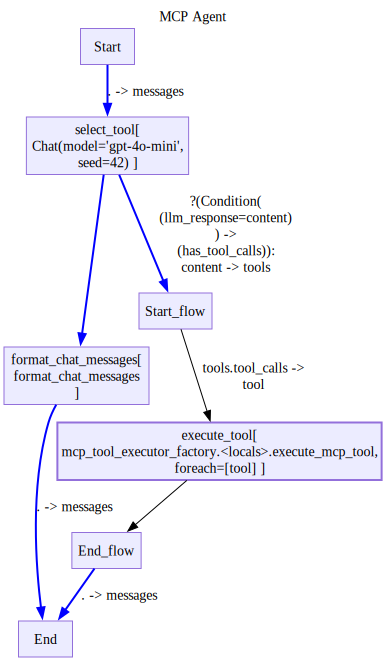

In [ ]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)
mcp_chat.draw(direction='TB')

In [ ]:
d0 = mcp_chat()
user_input = "What is love?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d0.run(messages):
    trace.pprint()

In [ ]:
d1 = mcp_chat()
user_input = "What information do I have about dogs in our wiki?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d1.run(messages):
    trace.pprint()

In [ ]:
d = mcp_chat()
user_input = user_query="What information do I have about dogs in our wiki, and what are the latest news or recent developments about dogs?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d.run(messages):
    trace.pprint()
    #trace.pprint(drop_keys=['input'])

# Diagram v4

In [ ]:
from pydantic import ConfigDict

In [ ]:
# State class to manage conversation history
class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()

    def append_to_history(self, value: int | list[int]):
        if isinstance(value, list):
            self.history.extend(value)
        else:
            self.history.append(value)
    
    def get_history(self)->int:
        return self.history

In [ ]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)

In [ ]:
#| export
def has_tool_result(mcp_output: Dict[str, Any]) -> bool:
    """
    Check if the mcp_chat output contains at least one tool_result in messages.
    
    Args:
        mcp_output: Output from mcp_chat sub-diagram, should have a 'messages' key
        
    Returns:
        True if any message has content with type 'tool_result', False otherwise
    """    
    messages = mcp_output.get('messages', [])
    # Iterate through each message
    for message in messages:
        if not isinstance(message, dict):
            continue
            
        content = message.get('content', [])
        
        # Handle content as a list
        if isinstance(content, list):
            for item in content:
                if isinstance(item, dict) and item.get('type') == 'tool_result':
                    return True
        
        # Handle content as a string (no tool_result)
        elif isinstance(content, str):
            continue
    
    return False

In [ ]:

with Define('MCP Chat Loop', type='decision', state=CustomState()) as MCP_Chat_Loop:
    # Get user info/input
  E('Start->state/append_to_history')
    
    # Run MCP Chat as a sub-diagram
  V('mcp_chat', mcp_chat,
      inputs=['Start(_=.)',
      'State/get_history'],
      outputs=['State/append_to_history(0=messages)']
      )
  E('mcp_chat->mcp_chat', Condition(has_tool_result))
  E('mcp_chat->End')




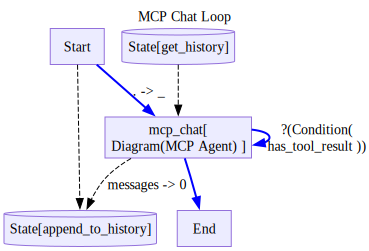

In [ ]:
MCP_Chat_Loop.draw(direction='TB')

In [ ]:
d = MCP_Chat_Loop()
user_input = "What information do I have about dogs in our wiki?"
message = {"role": "user", "content": user_input}
for trace in d.run(message):
    trace.pprint()
    print(d.state)

history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_id': 'call_BZikRpXHnbbewd37tNPkaVbI', 'tool_name': 'filesystem_search_files', 'content': ['/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki/dogs.md']}]}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_id': 'call_BZikRpXHnbbewd37tNPkaVbI', 'tool_name': 'filesystem_search_files', 'content': ['/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki/dogs.md']}]}]


ValueError: When running node 'select_tool[None]':
Function Chat(model='gpt-4o-mini', seed=42)
args=[]
kwargs={'messages': [{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_id': 'call_BZikRpXHnbbewd37tNPkaVbI', 'tool_name': 'filesystem_search_files', 'content': ['/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki/dogs.md']}]}]}
returned Error 
'Error code: 400 - {'error': {'message': "Invalid value: 'tool_result'. Supported values are: 'text', 'image_url', 'input_audio', 'refusal', 'audio', and 'file'.", 'type': 'invalid_request_error', 'param': 'messages[1].content[0].type', 'code': 'invalid_value'}}'


In [ ]:
history = d.state.get_history()

In [ ]:
d1 = mcp_chat()
for trace in d1.run(history):
    trace.pprint()

history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_id': 'call_BZikRpXHnbbewd37tNPkaVbI', 'tool_name': 'filesystem_search_files', 'content': ['/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki/dogs.md']}]}]


ValueError: When running node 'select_tool[None]':
Function Chat(model='gpt-4o-mini', seed=42)
args=[]
kwargs={'messages': [{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_id': 'call_BZikRpXHnbbewd37tNPkaVbI', 'tool_name': 'filesystem_search_files', 'content': ['/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki/dogs.md']}]}]}
returned Error 
'Error code: 400 - {'error': {'message': "Invalid value: 'tool_result'. Supported values are: 'text', 'image_url', 'input_audio', 'refusal', 'audio', and 'file'.", 'type': 'invalid_request_error', 'param': 'messages[1].content[0].type', 'code': 'invalid_value'}}'
